# Scalable Vertex Recognition

#### imports

In [253]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

#### input

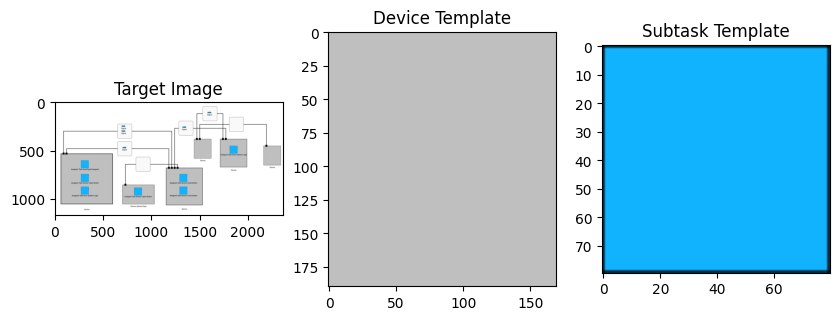

In [254]:
activate_plotly = False # turn expensive renderings on and off

# Define the paths
target_image_path = 'images/testcase3.png' # version 2 for paper with scaled vertex
device_template_path = 'images/device.png'
subtask_template_path = 'images/subtask.png'

target_img = cv2.imread(target_image_path)
device_template= cv2.imread(device_template_path)
subtask_template = cv2.imread(subtask_template_path)

device_template = cv2.resize(device_template, (180, 200))
subtask_template = cv2.resize(subtask_template, (80, 80))

device_template = device_template[5:-5, 5:-5]
original_image = target_img.copy()

# Draw target image, device template, and subtask template
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')
ax[1].imshow(cv2.cvtColor(device_template, cv2.COLOR_BGR2RGB))
ax[1].set_title('Device Template')
ax[2].imshow(cv2.cvtColor(subtask_template, cv2.COLOR_BGR2RGB))
ax[2].set_title('Subtask Template')
plt.show()

#### finding subtasks first and drawing a grey box over them for further processing

subtask 1 at: (1809, 460)
subtask 2 at: (269, 610)
subtask 3 at: (269, 750)
subtask 4 at: (1289, 750)
subtask 5 at: (269, 880)
subtask 6 at: (1289, 880)
subtask 7 at: (819, 890)


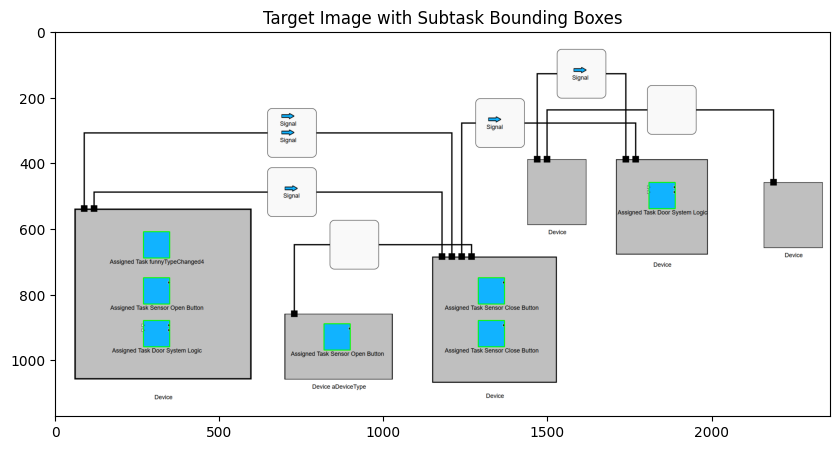

In [255]:
res = cv2.matchTemplate(target_img, subtask_template, cv2.TM_CCOEFF_NORMED)
# Threshold the result
threshold = 0.8
loc = np.where(res >= threshold)

subtasks = [(int(pt[0]), int(pt[1])) for pt in zip(*loc[::-1])]
# Draw grey boxes over the subtasks, 10 pixels bigger in every direction
for pt in subtasks:
    top_left = (pt[0] - 10, pt[1] - 10)
    bottom_right = (pt[0] + subtask_template.shape[1] + 10, pt[1] + subtask_template.shape[0] + 10)
    cv2.rectangle(target_img, top_left, bottom_right, (191, 191, 191), -1)
for i, pt in enumerate(zip(*loc[::-1])):
    print(f"subtask {i+1} at: ({int(pt[0])}, {int(pt[1])})")

# Draw the bounding boxes for the subtask templates
target_img_with_subtask_boxes = original_image.copy()
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + subtask_template.shape[1], pt[1] + subtask_template.shape[0])
    cv2.rectangle(target_img_with_subtask_boxes, pt, bottom_right, (0, 255, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_subtask_boxes, cv2.COLOR_BGR2RGB))
plt.title('Target Image with Subtask Bounding Boxes')
plt.show()

## Template Matching

Use opencv template matching: https://docs.opencv.org/4.10.0/df/dfb/group__imgproc__object.html

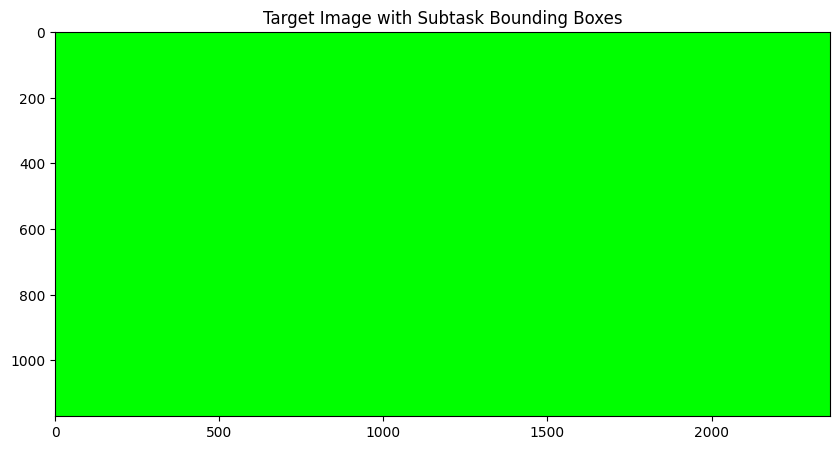

In [256]:
res = cv2.matchTemplate(target_img, device_template, cv2.TM_CCOEFF_NORMED)
# Threshold the result
threshold = 0.5
loc = np.where(res >= threshold)

devices = [(int(pt[0]), int(pt[1])) for pt in zip(*loc[::-1])]

# Draw the bounding boxes for the subtask templates
target_img_with_device_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + device_template.shape[1], pt[1] + device_template.shape[0])
    cv2.rectangle(target_img_with_device_boxes, pt, bottom_right, (0, 255, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_device_boxes, cv2.COLOR_BGR2RGB))
plt.title('Target Image with Subtask Bounding Boxes')
plt.show()

## Visualization after Thresholding

### Analysis After Thresholding

In [257]:
# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

### 2D Visualization

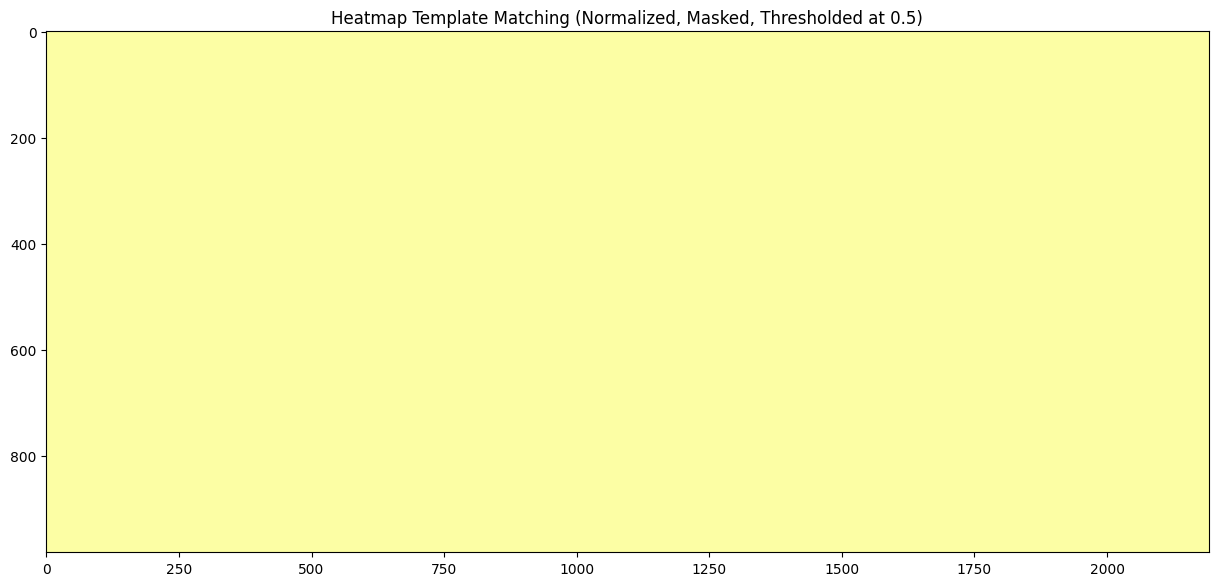

In [258]:
# Draw the thresholded results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cax = ax.imshow(loc, cmap='inferno', vmin=0, vmax=1)
ax.imshow(thresholded_res, cmap='inferno', vmin=0, vmax=1)
ax.set_title(f'Heatmap Template Matching (Normalized, Masked, Thresholded at {threshold})')
# fig.colorbar(cax, ax=ax) # optional colorbar
plt.show()

### 2D on Target Image

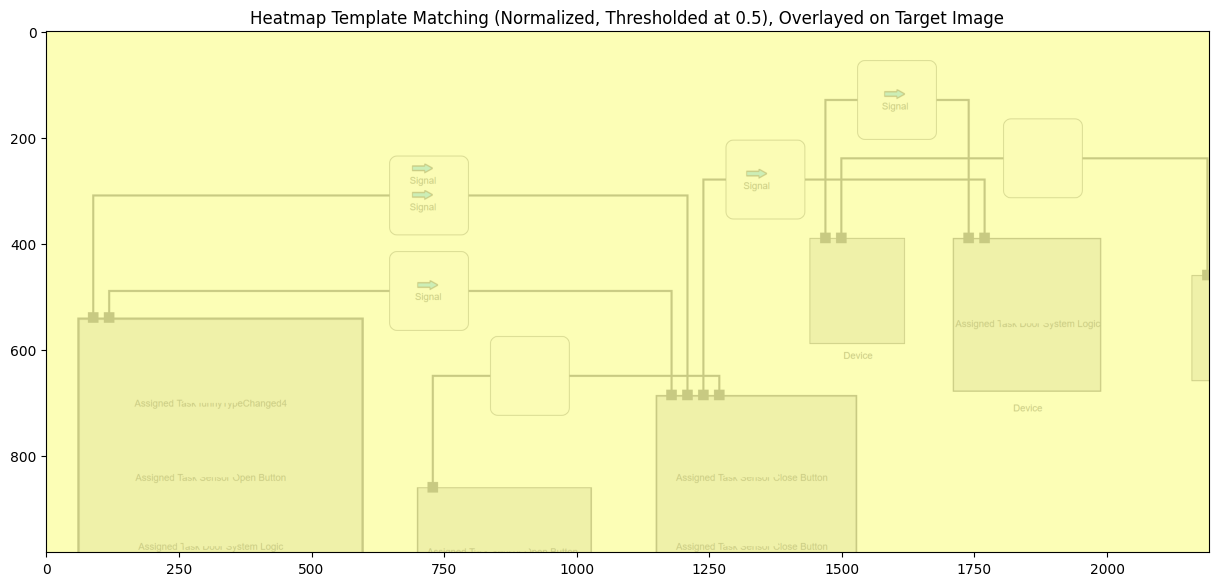

In [259]:
# Overlay the heatmap on the original image
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(thresholded_res, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title(f'Heatmap Template Matching (Normalized, Thresholded at {threshold}), Overlayed on Target Image')
plt.show()


#### 2D big Xes on Target Image
Xes are easy to see, but their color does not provide a colorscale

TODO: add this visualization to actual code base

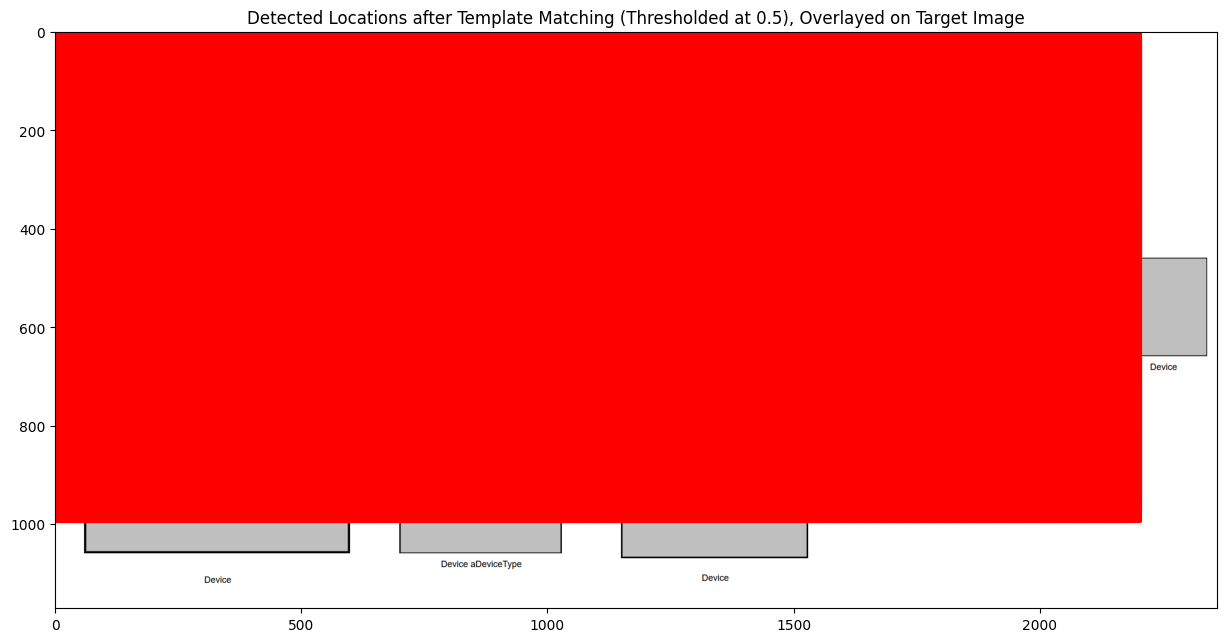

In [260]:
# draw the loc as points
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.scatter(loc[1], loc[0], c='r', s=100, marker='x')
plt.title(f'Detected Locations after Template Matching (Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

### 3D with Plotly

In [261]:
if activate_plotly: # not as expensive anymore, way less pixels
  fig = go.Figure(
    data=[go.Surface(
      z=thresholded_res)]
    )
  fig.update_layout(title=f'Heatmap Template Matching (Normalized, Thresholded at {threshold})', 
                    scene=dict(
                      zaxis=dict(range=[threshold, 1]),
                      yaxis=dict(autorange='reversed'), # This reverses the y-axis in a 3D plot    --- use this, super good!
                    ), 
                    height=1200)
  fig.show()

### 2D with Plotly

In [262]:
# again with plotly, but 2D
if activate_plotly:
  fig = go.Figure(
    data=go.Heatmap(
      z=thresholded_res,
      ),
    )
  fig.update_layout(title='Heatmap Template Matching (Normalized, Thresholded)', 
                    scene=dict(
                      yaxis=dict(autorange='reversed') 
                    ), # This reverses the y-axis in a 3D plot    --- use this, super good!
                    height=1200)
  fig.show()


## From Pixels to Boxes

### Bounding Boxes before Foreground check
Draw bounding boxes for every single matched template. (A 180x200 box for every single pixel)

In [ ]:
# Draw the bounding boxes
target_img_with_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + device_template.shape[1], pt[1] + device_template.shape[0])
    cv2.rectangle(target_img_with_boxes, pt, bottom_right, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Target Image with Bounding Boxes')  
plt.show()

### Threshold to get Foreground
Original target image is thresholded to get foreground. This is used to restrict matches to the foreground. TODO: is this still a thing?

In [ ]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, target_thresh = cv2.threshold(target_gray, 245, 255, cv2.THRESH_BINARY_INV)

### Visualize Foreground

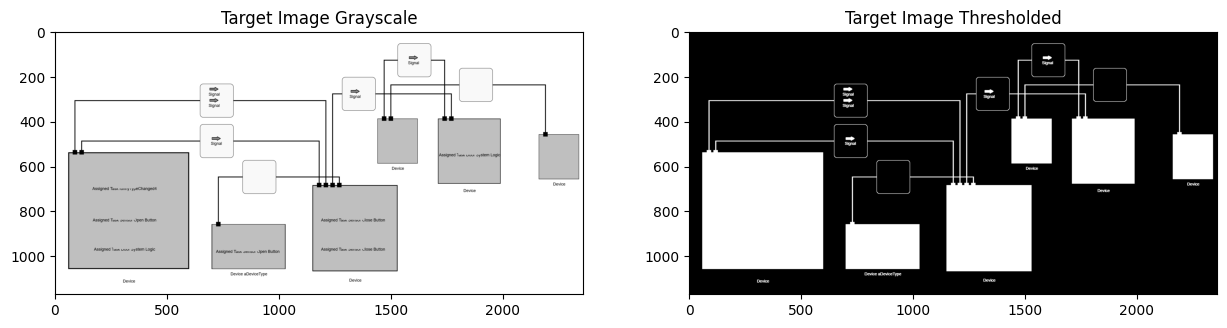

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(target_gray, cmap='gray')
ax[0].set_title('Target Image Grayscale')
ax[1].imshow(target_thresh, cmap='gray')
ax[1].set_title('Target Image Thresholded')
plt.show()

### Filter Foreground
Filters the bounding boxes of the vertices. Only locations in the foreground are kept. This is probably obsolete. 

In [ ]:
loc_foreground = []
for pt in zip(*loc[::-1]):
    if np.all(target_thresh[pt[1]:pt[1] + device_template.shape[0], pt[0]:pt[0] + device_template.shape[1]] == 255):
        loc_foreground.append(pt)

### Visualize Bounding Boxes after Foreground Filtering

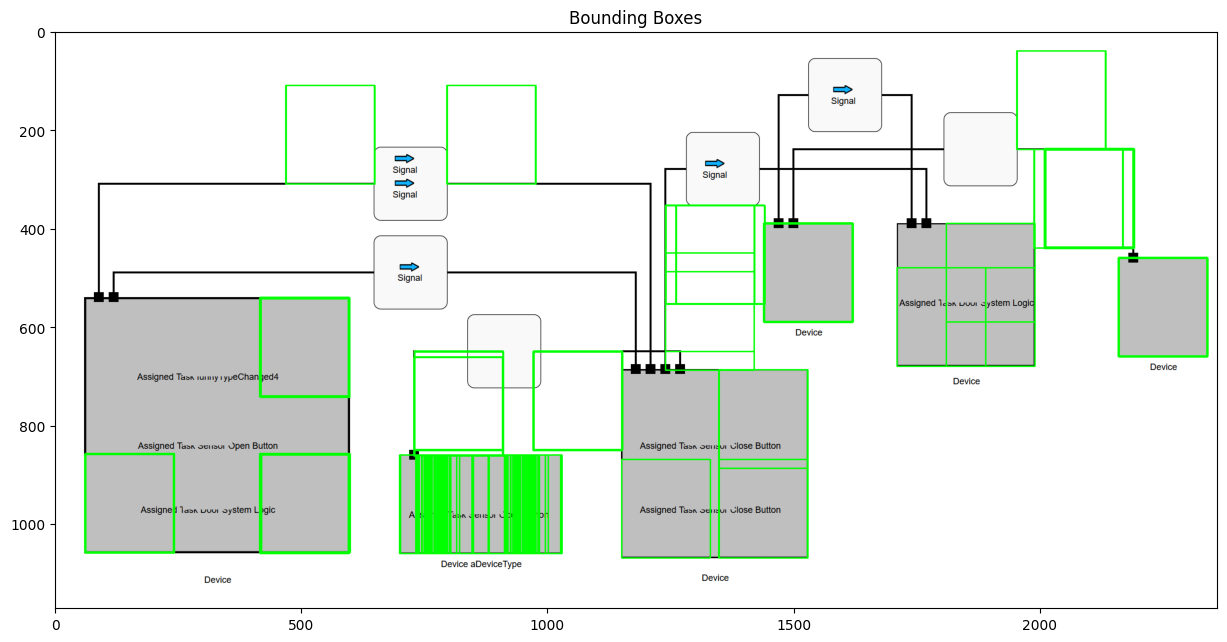

In [ ]:
target_img_bounding_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(target_img_bounding_boxes, pt, (pt[0] + device_template.shape[1], pt[1] + device_template.shape[0]), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_bounding_boxes, cv2.COLOR_BGR2RGB))
ax.set_title('Bounding Boxes')
plt.show()

### Analyse Foreground Check
Foregound check has currently negligible effect and could be deactivated.

In [ ]:
# Compare loc and loc_foreground
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")
print(f"Found {len(loc_foreground)} matches with a threshold of {threshold} and foreground filter")

Found 152 matches with a threshold of 0.5
Found 99 matches with a threshold of 0.5 and foreground filter


#### Visualize Remaining Matches after Foreground Filter

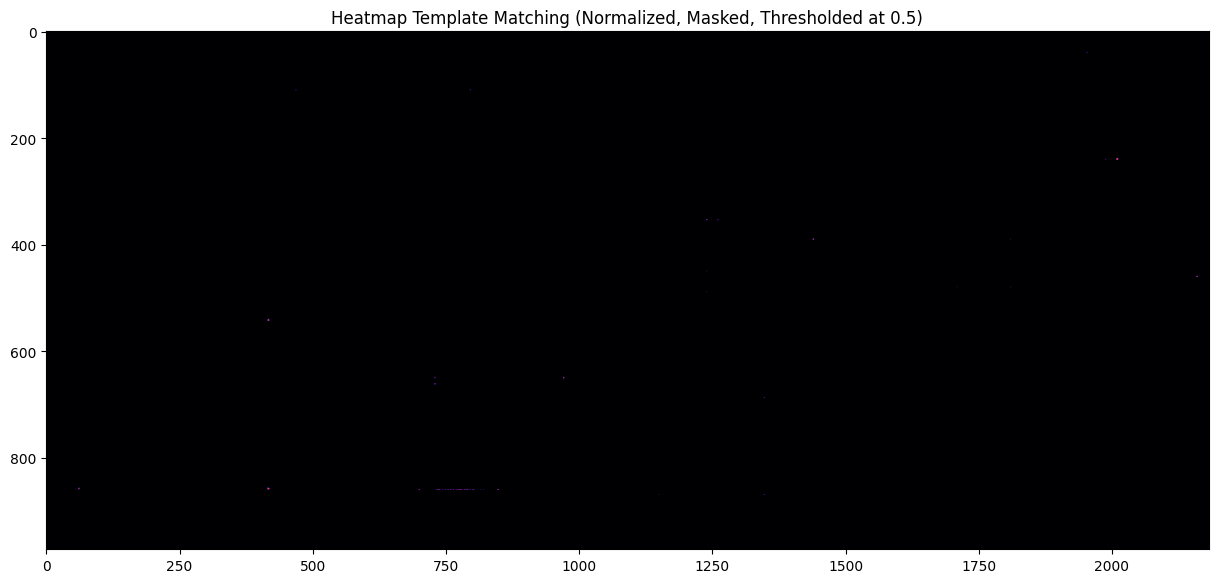

In [ ]:
# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

# Draw the thresholded results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cax = ax.imshow(loc, cmap='inferno', vmin=0, vmax=1)
ax.imshow(thresholded_res, cmap='inferno', vmin=0, vmax=1)
ax.set_title(f'Heatmap Template Matching (Normalized, Masked, Thresholded at {threshold})')
# fig.colorbar(cax, ax=ax) # optional colorbar
plt.show()

#### ... on Target Image

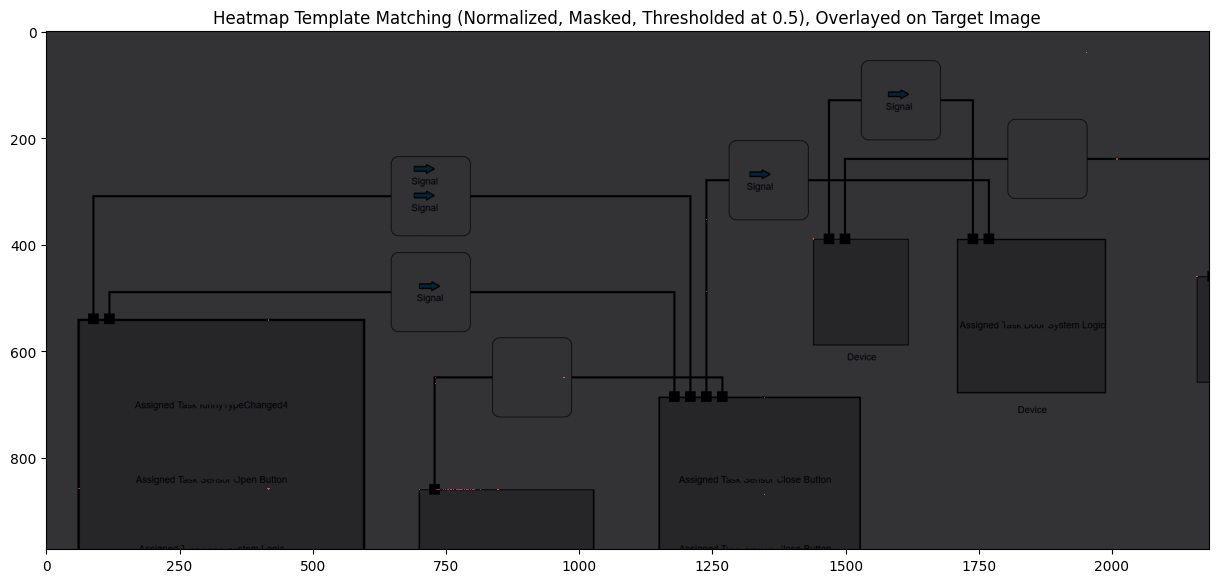

In [ ]:
# Overlay the heatmap on the original image
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(thresholded_res, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title(f'Heatmap Template Matching (Normalized, Masked, Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

Idea. To distinguish between differently coloured boxes do comparison above the threshold which coloured box gets the most points. Old idea. It is easier if it finds every box with confidence. 

### Fill bounding boxes
Fills the bounding boxes of the vertices

In [ ]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in loc_foreground:
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + device_template.shape[1], pt[1] + device_template.shape[0]), 255, -1)

#### Plot filled bounding boxes

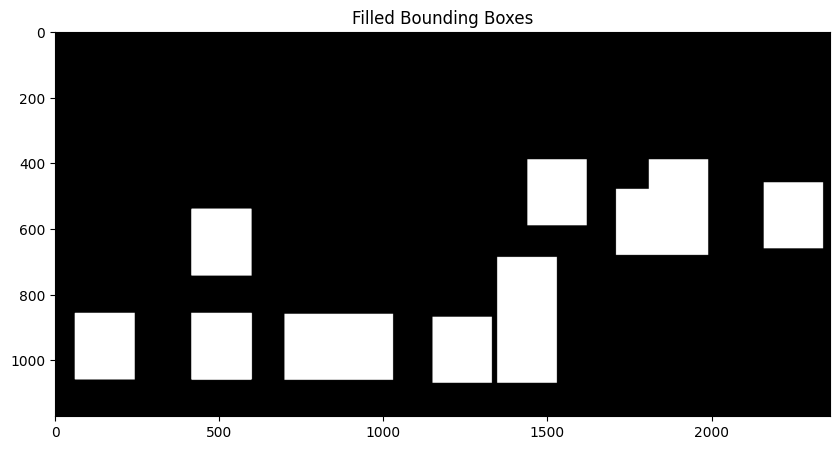

In [ ]:
# Draw the filled bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matched_templates_bbox_filled, cmap='gray')
ax.set_title('Filled Bounding Boxes')
plt.show()

### Find Contours in the super boxes
The overlapping bounding boxes are now puzzled together to big boxes

In [ ]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours and save their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (0, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))
print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(1150, 869, 181, 201), (699, 860, 331, 201), (415, 857, 185, 204), (60, 857, 183, 203), (1347, 687, 182, 383), (415, 540, 184, 204), (2159, 460, 181, 201), (1709, 390, 281, 291), (1439, 390, 181, 201)]


#### Visualize the super boxes

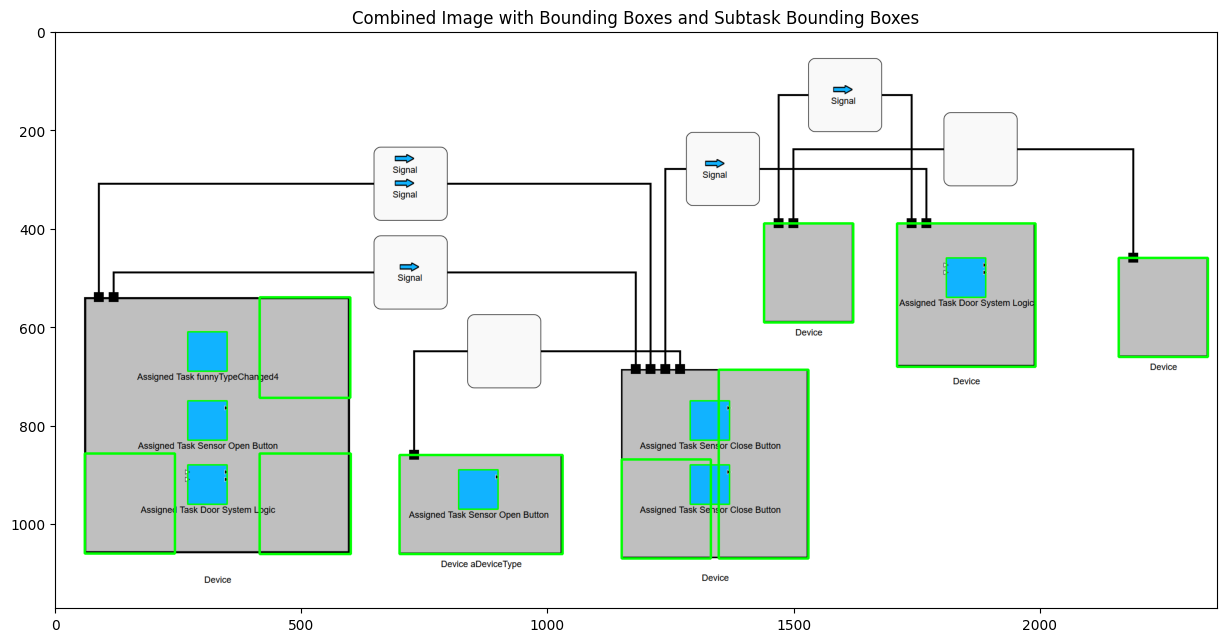

In [ ]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Overlay the bounding boxes detected templates on the initial target image with subtask bounding boxes
combined_image = target_img_with_subtask_boxes.copy()
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(combined_image, (x, y), (x+w, y+h), (0, 255, 0), 4)

ax.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
ax.set_title("Combined Image with Bounding Boxes and Subtask Bounding Boxes")

plt.show()